In [2]:
import numpy as np
import pandas as pd

In [11]:
dat = pd.read_csv("C://rga_test/ru.csv", sep=";", engine="c", encoding="cp1251")

In [16]:
print(dat.columns)

Index(['ID', 'status', 'status extra', 'country', 'city', 'date add',
       'program id', 'name*', 'surname*', 'tel*', 'email*',
       'contact person name*', 'contact person surname*', 'diagnose',
       'Disease name (in program)',
       'removed (?1-удален; 2-в архиве; 3-успешно завершен; 4-current casses 5 - cusstom paid consultation; 6-pre sales )',
       'current clinic name', 'Department', 'Sales manager 1',
       'Sales manager 2', 'Travel manager', 'MHS', 'source', 'Payment'],
      dtype='object')


In [23]:
y = dat["removed (?1-удален; 2-в архиве; 3-успешно завершен; 4-current casses 5 - cusstom paid consultation; 6-pre sales )"]

In [135]:
x = dat[['email*','contact person name*',"diagnose"]]
x = x.fillna("")

In [136]:
# quan_words
x = x.assign(quan_words= x["diagnose"].apply(lambda t: len(t.split())).values)
# question
x = x.assign(question= x["diagnose"].apply(lambda t: t.count("?")).values)
# has_contact
x = x.assign(has_contact= x["contact person name*"].apply(lambda t: 0 if not t else 1).values)
# without_stops
x = x.assign(without_stops= x["diagnose"].apply(lambda t: 0 if any(i in t for i in '.,;:?!') else 1).values)
# has_digit
x = x.assign(has_digit= x["diagnose"].apply(lambda t: 1 if any(i in t for i in '1234567890') else 0).values)
# big_letters
x = x.assign(big_letters= x["diagnose"].apply(lambda t: sum(1 if t[ind].isupper() and t[ind+1].isupper() and t[ind-1].islower else 0 
                                                            for ind in range(0,len(t)-1))).values)
# not_empty
x = x.assign(not_empty= x["diagnose"].apply(lambda t: 0 if not t else 1).values)
# gmail
x = x.assign(gmail= x["email*"].apply(lambda t: 1 if "gmail.com" in t else 0).values)
# mailru
x = x.assign(mailru= x["email*"].apply(lambda t: 1 if "mail.ru" in t else 0).values)
# ukrnet
x = x.assign(ukrnet= x["email*"].apply(lambda t: 1 if "ukr.net" in t else 0).values)
# other
x = x.assign(other=pd.Series([0 if row["ukrnet"] or row["mailru"] or row["gmail"] else 1 for ind,row in x.iterrows()]))
# is_proper
x = x.assign(is_proper= x["diagnose"].apply(lambda t: 1 if t==t.capitalize() else 0).values)

In [137]:
#lowercase diagnose
x["diagnose"] = x["diagnose"].apply(lambda t: t.lower())

# has_bol
x = x.assign(has_bol= x["diagnose"].apply(lambda t: 1 if "бол" in t else 0).values)

# has_cancer
x = x.assign(has_bol= x["diagnose"].apply(lambda t: 1 if "рак" in t else 0).values)

# has_prost
x = x.assign(has_bol= x["diagnose"].apply(lambda t: 1 if "простат" in t else 0).values)

# has_grud
x = x.assign(has_bol= x["diagnose"].apply(lambda t: 1 if "груд" in t else 0).values)

# has_balka
x = x.assign(has_bol= x["diagnose"].apply(lambda t: 1 if "|" in t else 0).values)

In [138]:
x = x.drop('contact person name*', 1)
x = x.drop('email*', 1)
x = x.drop('diagnose', 1)

In [113]:
y = y.apply(lambda t: 1 if t==3 or t==4 or t==5 else 0)

In [141]:
print (x.head())
print (y.head())

   quan_words  question  has_contact  without_stops  has_digit  big_letters  \
0           0         0            1              1          0            0   
1           3         0            1              1          0            0   
2           0         0            0              1          0            0   
3           1         0            1              1          0            0   
4           7         0            1              1          0            0   

   not_empty  gmail  mailru  ukrnet  other  is_proper  has_bol  
0          0      1       0       0      0          1        0  
1          1      1       0       0      0          1        0  
2          0      0       1       0      0          1        0  
3          1      0       0       1      0          1        0  
4          1      1       0       0      0          1        0  
0    0
1    0
2    0
3    0
4    0
Name: removed (?1-удален; 2-в архиве; 3-успешно завершен; 4-current casses 5 - cusstom paid consulta

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [155]:
param_grid = {'C': [0.0009, 0.001, 0.01, 0.1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf = clf.fit(x, y)
print(clf)
# View the accuracy score
print('Best score for data1:', clf.best_score_)
print('Best C:',clf.best_estimator_.C)
print('Best C:',clf.best_estimator_.coef_)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0009, 0.001, 0.00095, 0.00085, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
Best score for data1: 0.962527964206
Best C: 0.0009
Best C: [[-0.24533934  0.00039512 -0.12078528 -0.34483889 -0.00389165 -0.04768777
  -0.15921051 -0.07785386 -0.14570733 -0.01129144 -0.12521838 -0.28622202
   0.00100811]]


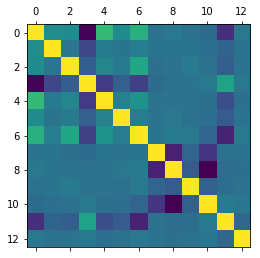

In [143]:
plt.matshow(x.corr())